In [1]:
import os
import difflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches as mpatches

import sys
sys.path.append('../../')
from rllte.evaluation.visualization import _annotate_and_decorate_axis, plot_interval_estimates
from rllte.evaluation import Performance

In [7]:
root = 'C:/Users/BIRL/Downloads/nips2024_data/q6/'
for folder in os.listdir(root):
    if folder == '.DS_Store':
        continue
    if len(os.listdir(os.path.join(root, folder))) != 1:
        print(folder, os.listdir(os.path.join(root, folder)))

In [11]:
algos = ['ICM', 'Disagreement', 'E3B', 'RND', 'PseudoCounts', 'RIDE', 'RE3', 'NGU']
# root = "/Users/yuanmingqi/Downloads/nips2024_data/q3/01/"

envs = ['1MazeHard', '1MazeMemory', 'AllMazeHard', 'AllMazeMemory']

for env in envs:
    root = f'C:/Users/BIRL/Downloads/nips2024_data/q6/{env}'
    num_points = 10
    all_data = {algo: [] for algo in algos}
    for algo in algos:
        for dir in os.listdir(root):
            if algo.lower() in dir:
                file = f"{root}/{dir}/"
                file = file + difflib.get_close_matches("2024-", os.listdir(file), 1, 0.1)[0] + '/train.log'
                data = pd.read_csv(file)#['episode_reward']
                if data['step'].values[-1] != 49999872:
                    print(env, dir)

1MazeHard PPO_1MazeHard-v0_disagreement_obsRMS_True_rewNorm_none_updateProp_1.0_rff_False_weightInit_orthogonal_s4
1MazeHard twoHeadPPO_1MazeHard-v0_disagreement_obsRMS_True_rewNorm_none_updateProp_1.0_rff_False_weightInit_orthogonal_s4
1MazeHard twoHeadPPO_1MazeHard-v0_e3b_obsRMS_False_rewNorm_rms_updateProp_0.5_rff_False_weightInit_orthogonal_s2
1MazeHard PPO_1MazeHard-v0_rnd_obsRMS_True_rewNorm_none_updateProp_1.0_rff_False_weightInit_orthogonal_s5
1MazeHard twoHeadPPO_1MazeHard-v0_rnd_obsRMS_True_rewNorm_none_updateProp_1.0_rff_False_weightInit_orthogonal_s4
1MazeMemory twoHeadPPO_1MazeMemory-v0_icm_obsRMS_True_rewNorm_none_updateProp_1.0_rff_False_weightInit_orthogonal_s4
1MazeMemory twoHeadPPO_LSTM_1MazeMemory-v0_disagreement_obsRMS_True_rewNorm_none_updateProp_1.0_rff_False_weightInit_orthogonal_s1
1MazeMemory twoHeadPPO_LSTM_1MazeMemory-v0_disagreement_obsRMS_True_rewNorm_none_updateProp_1.0_rff_False_weightInit_orthogonal_s3
1MazeMemory twoHeadPPO_LSTM_1MazeMemory-v0_disagreem

# 1 Maze Hard

PPO_ ICM (5, 1, 10)
PPO_ Disagreement (5, 1, 10)
PPO_ E3B (5, 1, 10)
PPO_ RND (5, 1, 10)
PPO_ PseudoCounts (3, 1, 10)
PPO_ RIDE (3, 1, 10)
PPO_ RE3 (5, 1, 10)
PPO_ NGU (3, 1, 10)
PPO_ Extrinsic (5, 1, 10)
twoHeadPPO_ ICM (5, 1, 10)
twoHeadPPO_ Disagreement (5, 1, 10)
twoHeadPPO_ E3B (5, 1, 10)
twoHeadPPO_ RND (5, 1, 10)
twoHeadPPO_ PseudoCounts (3, 1, 10)
twoHeadPPO_ RIDE (3, 1, 10)
twoHeadPPO_ RE3 (5, 1, 10)
twoHeadPPO_ NGU (3, 1, 10)
twoHeadPPO_ Extrinsic (0, 1)


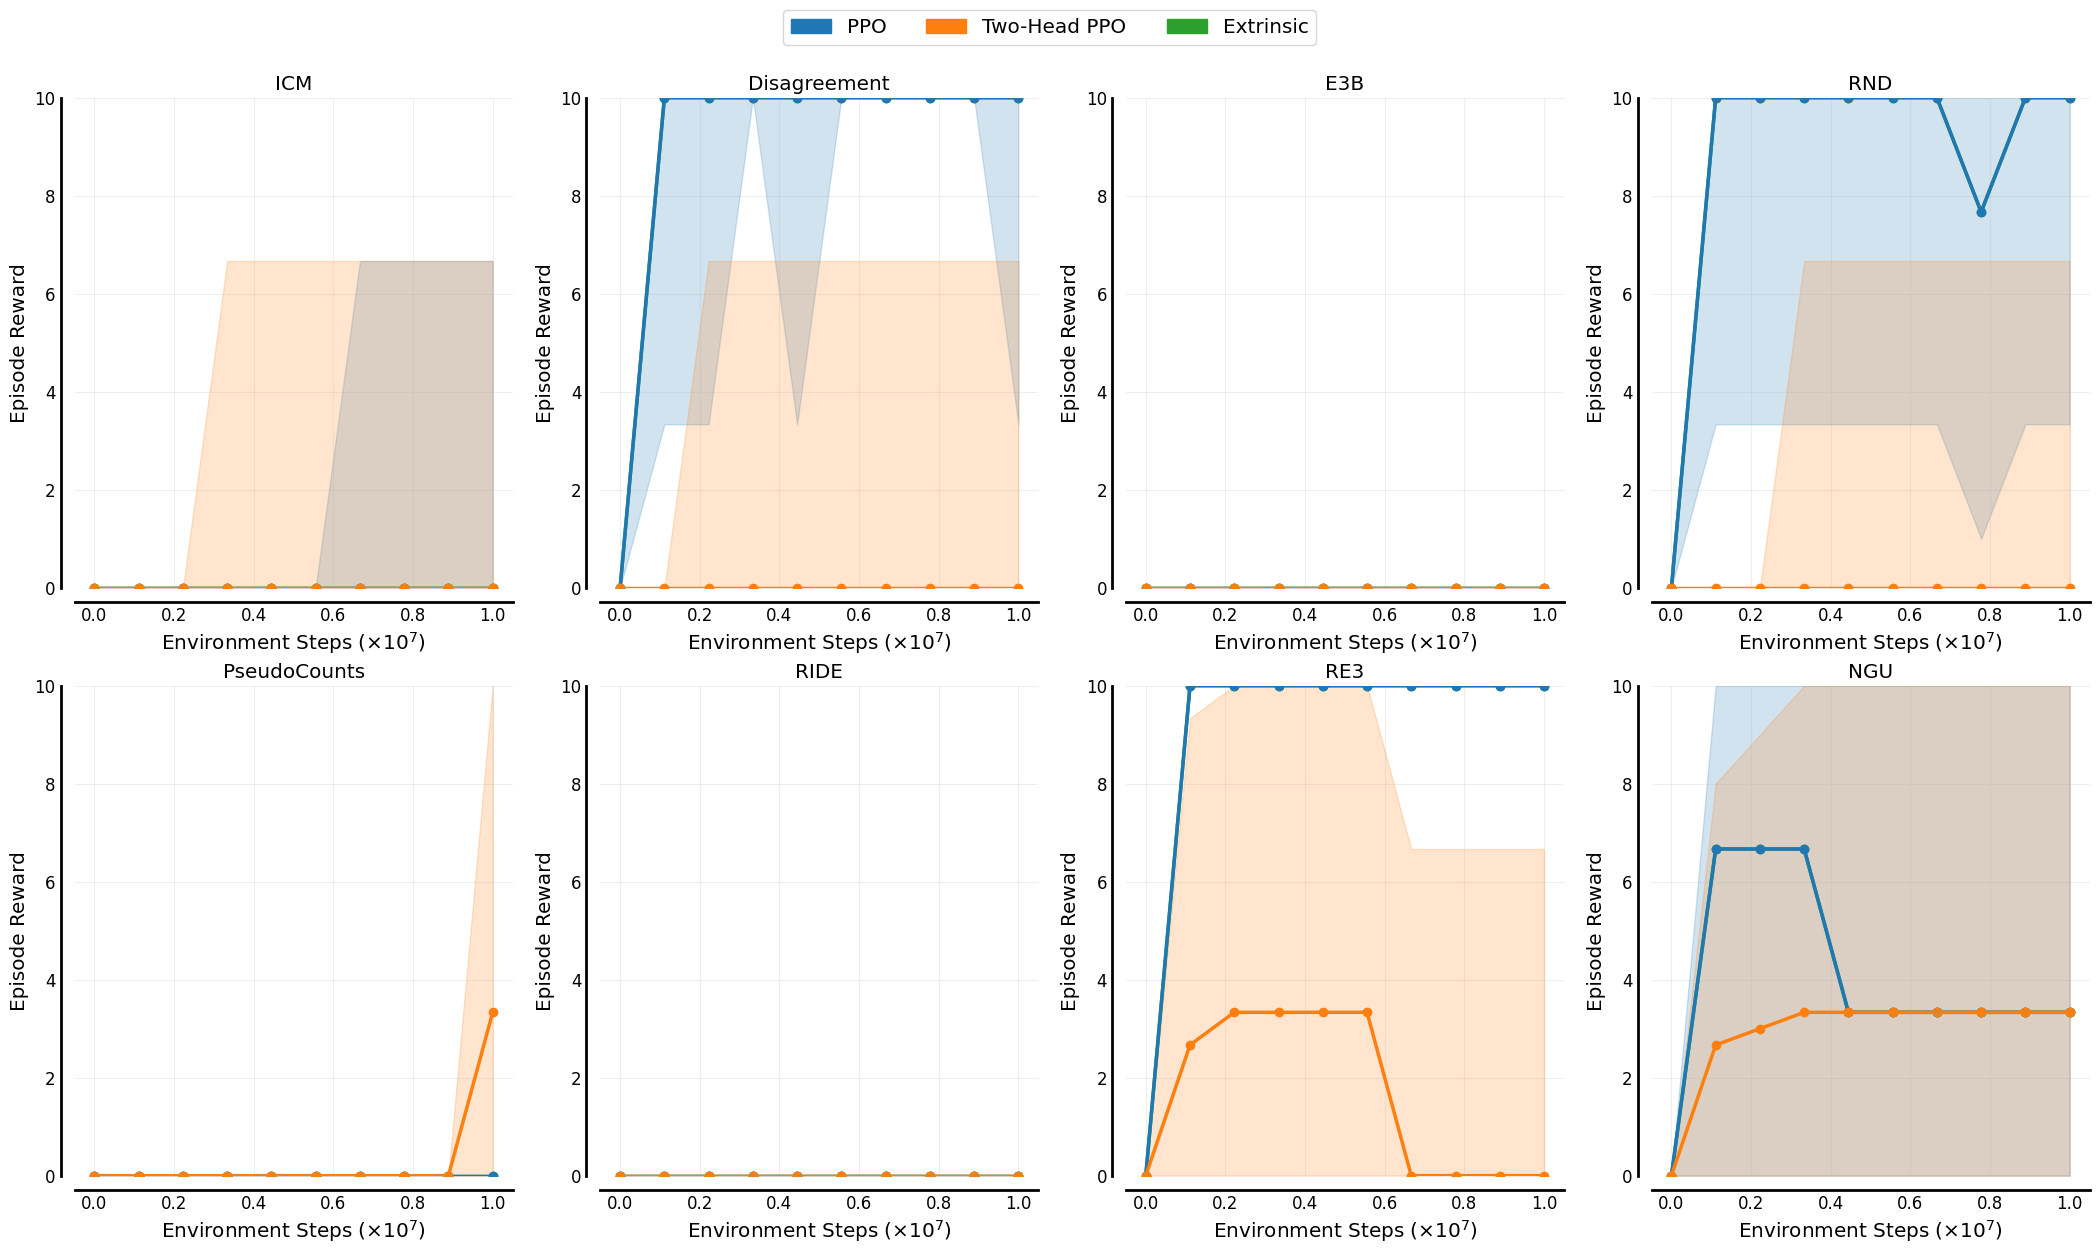

In [3]:
algos = ['ICM', 'Disagreement', 'E3B', 'RND', 'PseudoCounts', 'RIDE', 'RE3', 'NGU', 'Extrinsic']
# colors = sns.color_palette("husl", len(algos))
# colors = sns.husl_palette(3, h=.5)
colors = sns.color_palette()
fake_patches = [mpatches.Patch(color=colors[i], label=alg) for i, alg in enumerate(['PPO', 'Two-Head PPO', 'Extrinsic'])]

fig, axes = plt.subplots(2, 4, figsize=(26, 14))
legends = ['PPO', 'Two-Head PPO']
lines = []

for subplot_idx, candidate in enumerate(['PPO_', 'twoHeadPPO_']):
    root = f"/Users/yuanmingqi/Downloads/nips2024_data/q6/1MazeHard/"
    num_points = 10
    all_data = {algo: [] for algo in algos}

    for algo in algos:
        for dir in os.listdir(root):
            if algo.lower() in dir and dir.startswith(candidate):
                file = f"{root}/{dir}/"
                file = file + difflib.get_close_matches("2024-", os.listdir(file), 1, 0.1)[0] + '/train.log'
                data = pd.read_csv(file)['episode_reward']
                data = data[np.linspace(0, data.shape[0]-1, num_points, dtype=int)]
                all_data[algo].append(data)

        all_data[algo] = np.array(all_data[algo])
        all_data[algo] = np.expand_dims(all_data[algo], axis=1)
        print(candidate, algo, all_data[algo].shape)

    sampling_dict = dict()
    for algo in algos:
        if algo.lower() == 'extrinsic' and subplot_idx == 1:
            continue
        sampling_dict[algo] = [[], [], []]
        for frame in range(num_points):
            perf = Performance(all_data[algo][:, :, frame], get_ci=True, reps=2000)
            value, CIs = perf.aggregate_iqm()
            sampling_dict[algo][0].append(value)
            sampling_dict[algo][1].append(CIs[0]) # lower bound
            sampling_dict[algo][2].append(CIs[1]) # upper bound

        sampling_dict[algo][0] = np.array(sampling_dict[algo][0]).reshape(-1)
        sampling_dict[algo][1] = np.array(sampling_dict[algo][1]).reshape(-1)
        sampling_dict[algo][2] = np.array(sampling_dict[algo][2]).reshape(-1)

    for algo_idx, algo in enumerate(algos[:-1]):
        mean, ci_high, ci_low = sampling_dict[algo]
        ax = axes.flatten()[algo_idx]
        x = np.linspace(0, 1, num_points)
        if subplot_idx == 0:
            # ax.axhline(y=30.0, color='k', linestyle='--', linewidth=2, label="Extrinsic")
            ax.plot(x, mean, linewidth=2.5, marker='o', markersize=6, c=colors[2], label='Extrinsic')
        ax.plot(x, mean, linewidth=2.5, marker='o', markersize=6, c=colors[subplot_idx], label=legends[subplot_idx])
        ax.fill_between(x, ci_high, ci_low, alpha=0.2, color=colors[subplot_idx])
        ax.set_ylim(0, 10)
        ax.set_title(algos[algo_idx], fontsize="x-large")
        ax = _annotate_and_decorate_axis(ax, 
                                        ticklabelsize="large",
                                        xlabel=r"Environment Steps ($\times 10^7$)", 
                                        ylabel="Episode Reward",
                                        xticklabels=np.linspace(0, 1, num_points),
                                        )
        
fig.legend(fake_patches, ['PPO', 'Two-Head PPO', 'Extrinsic'], loc='upper center', 
    fancybox=True, ncol=len(algos), 
    fontsize='x-large',
    bbox_to_anchor=(0.5, 0.95))
fig.savefig('figure_rq6_curves_1mazehard.pdf', bbox_inches='tight', dpi=300)

# 1 Maze Memory

PPO_1MazeMemory ICM (5, 1, 10)
PPO_1MazeMemory Disagreement (5, 1, 10)
PPO_1MazeMemory E3B (5, 1, 10)
PPO_1MazeMemory RND (5, 1, 10)
PPO_1MazeMemory PseudoCounts (3, 1, 10)
PPO_1MazeMemory RIDE (3, 1, 10)
PPO_1MazeMemory RE3 (5, 1, 10)
PPO_1MazeMemory NGU (3, 1, 10)
PPO_1MazeMemory Extrinsic (5, 1, 10)
twoHeadPPO_1MazeMemory ICM (5, 1, 10)
twoHeadPPO_1MazeMemory Disagreement (5, 1, 10)
twoHeadPPO_1MazeMemory E3B (5, 1, 10)
twoHeadPPO_1MazeMemory RND (5, 1, 10)
twoHeadPPO_1MazeMemory PseudoCounts (3, 1, 10)
twoHeadPPO_1MazeMemory RIDE (3, 1, 10)
twoHeadPPO_1MazeMemory RE3 (5, 1, 10)
twoHeadPPO_1MazeMemory NGU (3, 1, 10)
twoHeadPPO_1MazeMemory Extrinsic (0, 1)
PPO_LSTM_1MazeMemory ICM (5, 1, 10)
PPO_LSTM_1MazeMemory Disagreement (5, 1, 10)
PPO_LSTM_1MazeMemory E3B (5, 1, 10)
PPO_LSTM_1MazeMemory RND (5, 1, 10)
PPO_LSTM_1MazeMemory PseudoCounts (3, 1, 10)
PPO_LSTM_1MazeMemory RIDE (2, 1, 10)
PPO_LSTM_1MazeMemory RE3 (5, 1, 10)
PPO_LSTM_1MazeMemory NGU (3, 1, 10)
PPO_LSTM_1MazeMemory Extri

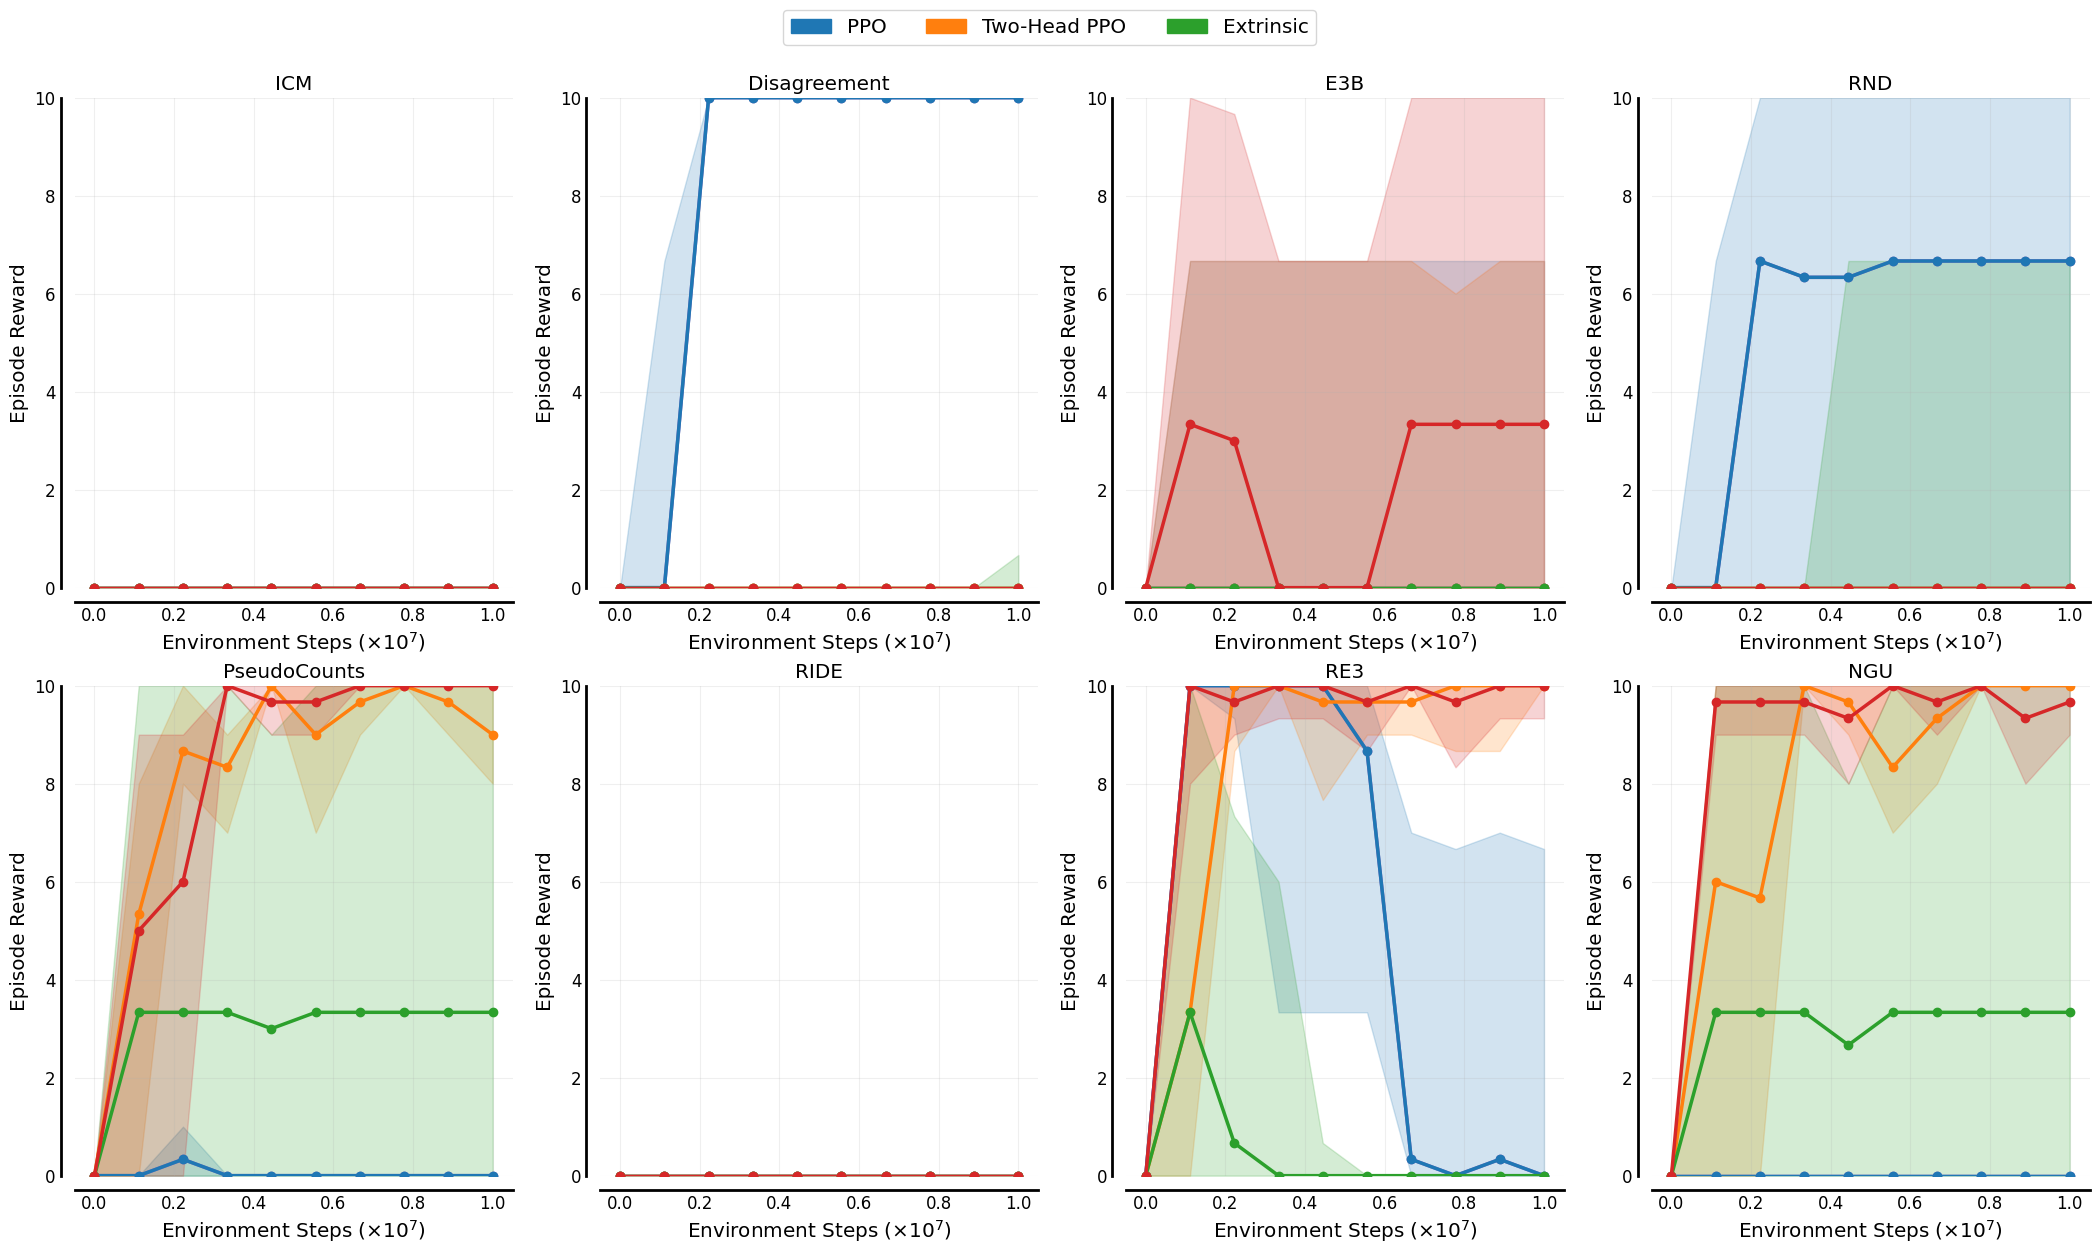

In [8]:
algos = ['ICM', 'Disagreement', 'E3B', 'RND', 'PseudoCounts', 'RIDE', 'RE3', 'NGU', 'Extrinsic']
# colors = sns.color_palette("husl", len(algos))
# colors = sns.husl_palette(3, h=.5)
colors = sns.color_palette()
fake_patches = [mpatches.Patch(color=colors[i], label=alg) for i, alg in enumerate(['PPO', 'Two-Head PPO', 'Extrinsic'])]

fig, axes = plt.subplots(2, 4, figsize=(26, 14))
legends = ['PPO', 'Two-Head PPO', 'PPO+LSTM', 'Two-Head PPO+LSTM']
lines = []

for subplot_idx, candidate in enumerate(['PPO_1MazeMemory', 
                                         'twoHeadPPO_1MazeMemory',
                                         'PPO_LSTM_1MazeMemory',
                                         'twoHeadPPO_LSTM_1MazeMemory'
                                         ]):
    root = f"/Users/yuanmingqi/Downloads/nips2024_data/q6/1MazeMemory/"
    num_points = 10
    all_data = {algo: [] for algo in algos}

    for algo in algos:
        for dir in os.listdir(root):
            if algo.lower() in dir and dir.startswith(candidate):
                file = f"{root}/{dir}/"
                file = file + difflib.get_close_matches("2024-", os.listdir(file), 1, 0.1)[0] + '/train.log'
                data = pd.read_csv(file)['episode_reward']
                data = data[np.linspace(0, data.shape[0]-1, num_points, dtype=int)]
                all_data[algo].append(data)

        all_data[algo] = np.array(all_data[algo])
        all_data[algo] = np.expand_dims(all_data[algo], axis=1)
        print(candidate, algo, all_data[algo].shape)

    sampling_dict = dict()
    for algo in algos:
        if algo.lower() == 'extrinsic' and subplot_idx != 0:
            continue
        sampling_dict[algo] = [[], [], []]
        for frame in range(num_points):
            perf = Performance(all_data[algo][:, :, frame], get_ci=True, reps=2000)
            value, CIs = perf.aggregate_iqm()
            sampling_dict[algo][0].append(value)
            sampling_dict[algo][1].append(CIs[0]) # lower bound
            sampling_dict[algo][2].append(CIs[1]) # upper bound

        sampling_dict[algo][0] = np.array(sampling_dict[algo][0]).reshape(-1)
        sampling_dict[algo][1] = np.array(sampling_dict[algo][1]).reshape(-1)
        sampling_dict[algo][2] = np.array(sampling_dict[algo][2]).reshape(-1)

    for algo_idx, algo in enumerate(algos[:-1]):
        mean, ci_high, ci_low = sampling_dict[algo]
        ax = axes.flatten()[algo_idx]
        x = np.linspace(0, 1, num_points)
        if subplot_idx == 0:
            # ax.axhline(y=30.0, color='k', linestyle='--', linewidth=2, label="Extrinsic")
            ax.plot(x, mean, linewidth=2.5, marker='o', markersize=6, c=colors[4], label='Extrinsic')
        ax.plot(x, mean, linewidth=2.5, marker='o', markersize=6, c=colors[subplot_idx], label=legends[subplot_idx])
        ax.fill_between(x, ci_high, ci_low, alpha=0.2, color=colors[subplot_idx])
        ax.set_ylim(0, 10)
        ax.set_title(algos[algo_idx], fontsize="x-large")
        ax = _annotate_and_decorate_axis(ax, 
                                        ticklabelsize="large",
                                        xlabel=r"Environment Steps ($\times 10^7$)", 
                                        ylabel="Episode Reward",
                                        xticklabels=np.linspace(0, 1, num_points),
                                        )
        
fig.legend(fake_patches, ['PPO', 'Two-Head PPO', 'Extrinsic'], loc='upper center', 
    fancybox=True, ncol=len(algos), 
    fontsize='x-large',
    bbox_to_anchor=(0.5, 0.95))
fig.savefig('figure_rq6_curves_1mazememory.pdf', bbox_inches='tight', dpi=300)

# All Maze Hard

PPO_ ICM (5, 1, 10)
PPO_ Disagreement (5, 1, 10)
PPO_ E3B (5, 1, 10)
PPO_ RND (5, 1, 10)
PPO_ PseudoCounts (3, 1, 10)
PPO_ RIDE (5, 1, 10)
PPO_ RE3 (5, 1, 10)
PPO_ NGU (3, 1, 10)
PPO_ Extrinsic (5, 1, 10)
twoHeadPPO_ ICM (5, 1, 10)
twoHeadPPO_ Disagreement (5, 1, 10)
twoHeadPPO_ E3B (5, 1, 10)
twoHeadPPO_ RND (5, 1, 10)
twoHeadPPO_ PseudoCounts (3, 1, 10)
twoHeadPPO_ RIDE (5, 1, 10)
twoHeadPPO_ RE3 (5, 1, 10)
twoHeadPPO_ NGU (3, 1, 10)
twoHeadPPO_ Extrinsic (0, 1)


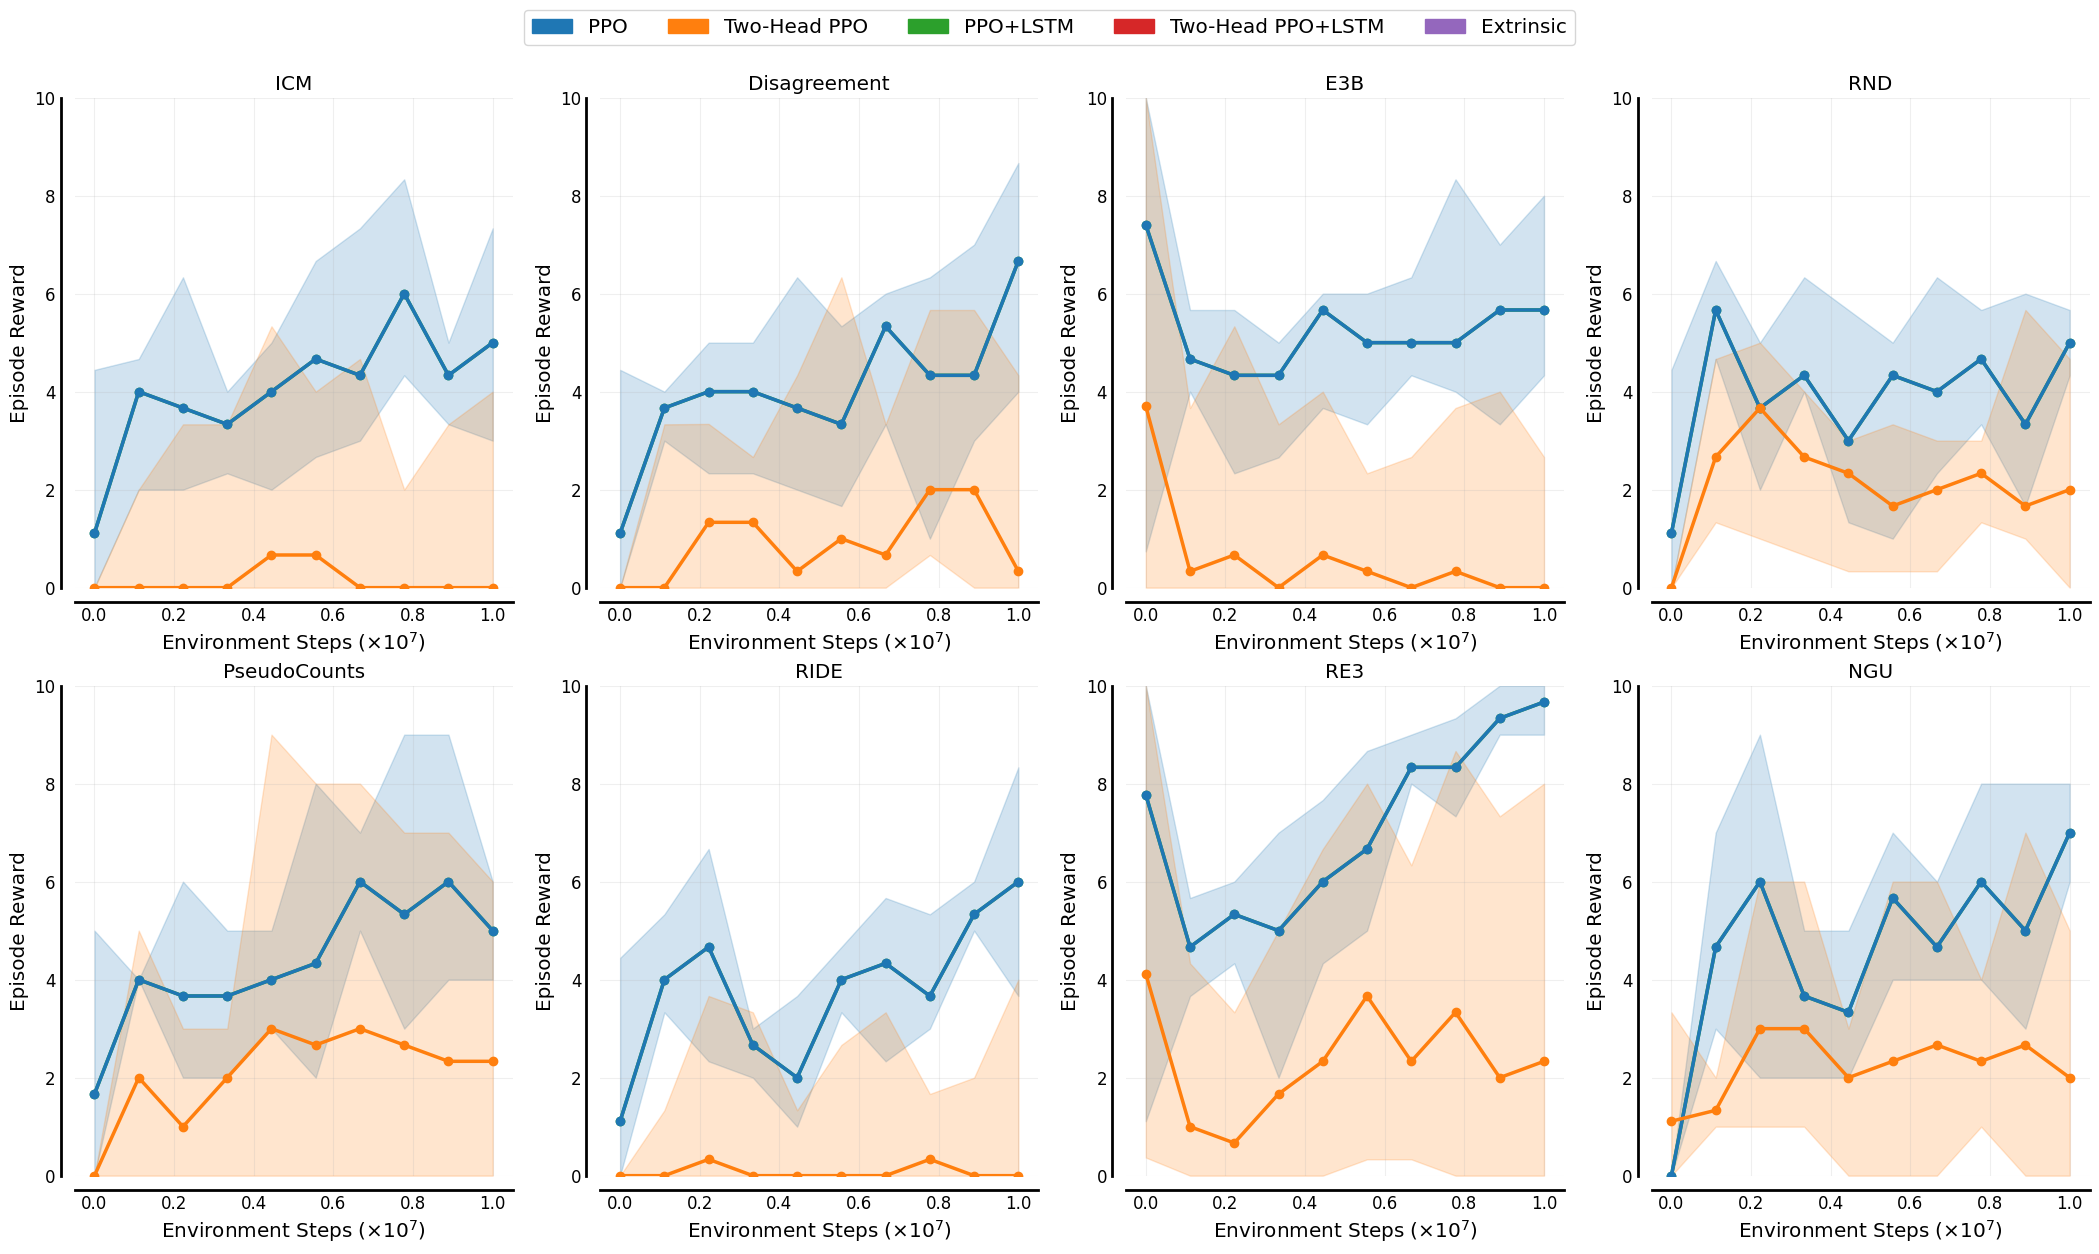

In [15]:
algos = ['ICM', 'Disagreement', 'E3B', 'RND', 'PseudoCounts', 'RIDE', 'RE3', 'NGU', 'Extrinsic']
# colors = sns.color_palette("husl", len(algos))
# colors = sns.husl_palette(3, h=.5)
colors = sns.color_palette()
fake_patches = [mpatches.Patch(color=colors[i], label=alg) for i, alg in enumerate(
    ['PPO', 'Two-Head PPO', 'PPO+LSTM', 'Two-Head PPO+LSTM', 'Extrinsic'])]

fig, axes = plt.subplots(2, 4, figsize=(26, 14))
legends = ['PPO', 'Two-Head PPO']
lines = []

for subplot_idx, candidate in enumerate(['PPO_', 'twoHeadPPO_']):
    root = f"/Users/yuanmingqi/Downloads/nips2024_data/q6/AllMazeHard/"
    num_points = 10
    all_data = {algo: [] for algo in algos}

    for algo in algos:
        for dir in os.listdir(root):
            if algo.lower() in dir and dir.startswith(candidate):
                file = f"{root}/{dir}/"
                file = file + difflib.get_close_matches("2024-", os.listdir(file), 1, 0.1)[0] + '/train.log'
                data = pd.read_csv(file)['episode_reward']
                data = data[np.linspace(0, data.shape[0]-1, num_points, dtype=int)]
                all_data[algo].append(data)

        all_data[algo] = np.array(all_data[algo])
        all_data[algo] = np.expand_dims(all_data[algo], axis=1)
        print(candidate, algo, all_data[algo].shape)

    sampling_dict = dict()
    for algo in algos:
        if algo.lower() == 'extrinsic' and subplot_idx == 1:
            continue
        sampling_dict[algo] = [[], [], []]
        for frame in range(num_points):
            perf = Performance(all_data[algo][:, :, frame], get_ci=True, reps=2000)
            value, CIs = perf.aggregate_iqm()
            sampling_dict[algo][0].append(value)
            sampling_dict[algo][1].append(CIs[0]) # lower bound
            sampling_dict[algo][2].append(CIs[1]) # upper bound

        sampling_dict[algo][0] = np.array(sampling_dict[algo][0]).reshape(-1)
        sampling_dict[algo][1] = np.array(sampling_dict[algo][1]).reshape(-1)
        sampling_dict[algo][2] = np.array(sampling_dict[algo][2]).reshape(-1)

    for algo_idx, algo in enumerate(algos[:-1]):
        mean, ci_high, ci_low = sampling_dict[algo]
        ax = axes.flatten()[algo_idx]
        x = np.linspace(0, 1, num_points)
        if subplot_idx == 0:
            # ax.axhline(y=30.0, color='k', linestyle='--', linewidth=2, label="Extrinsic")
            ax.plot(x, mean, linewidth=2.5, marker='o', markersize=6, c=colors[2], label='Extrinsic')
        ax.plot(x, mean, linewidth=2.5, marker='o', markersize=6, c=colors[subplot_idx], label=legends[subplot_idx])
        ax.fill_between(x, ci_high, ci_low, alpha=0.2, color=colors[subplot_idx])
        ax.set_ylim(0, 10)
        ax.set_title(algos[algo_idx], fontsize="x-large")
        ax = _annotate_and_decorate_axis(ax, 
                                        ticklabelsize="large",
                                        xlabel=r"Environment Steps ($\times 10^7$)", 
                                        ylabel="Episode Reward",
                                        xticklabels=np.linspace(0, 1, num_points),
                                        )
        
fig.legend(fake_patches, ['PPO', 'Two-Head PPO', 'PPO+LSTM', 'Two-Head PPO+LSTM', 'Extrinsic'], loc='upper center', 
    fancybox=True, ncol=len(algos), 
    fontsize='x-large',
    bbox_to_anchor=(0.5, 0.95))
fig.savefig('figure_rq6_curves_allmazehard.pdf', bbox_inches='tight', dpi=300)

# AllMazeMemory

PPO_AllMazeMemory ICM (5, 1, 10)
PPO_AllMazeMemory Disagreement (5, 1, 10)
PPO_AllMazeMemory E3B (5, 1, 10)
PPO_AllMazeMemory RND (5, 1, 10)
PPO_AllMazeMemory PseudoCounts (3, 1, 10)
PPO_AllMazeMemory RIDE (5, 1, 10)
PPO_AllMazeMemory RE3 (5, 1, 10)
PPO_AllMazeMemory NGU (3, 1, 10)
PPO_AllMazeMemory Extrinsic (5, 1, 10)
twoHeadPPO_AllMazeMemory ICM (5, 1, 10)
twoHeadPPO_AllMazeMemory Disagreement (5, 1, 10)
twoHeadPPO_AllMazeMemory E3B (5, 1, 10)
twoHeadPPO_AllMazeMemory RND (5, 1, 10)
twoHeadPPO_AllMazeMemory PseudoCounts (3, 1, 10)
twoHeadPPO_AllMazeMemory RIDE (5, 1, 10)
twoHeadPPO_AllMazeMemory RE3 (5, 1, 10)
twoHeadPPO_AllMazeMemory NGU (3, 1, 10)
twoHeadPPO_AllMazeMemory Extrinsic (0, 1)
PPO_LSTM_AllMazeMemory ICM (5, 1, 10)
PPO_LSTM_AllMazeMemory Disagreement (5, 1, 10)
PPO_LSTM_AllMazeMemory E3B (5, 1, 10)
PPO_LSTM_AllMazeMemory RND (5, 1, 10)
PPO_LSTM_AllMazeMemory PseudoCounts (3, 1, 10)
PPO_LSTM_AllMazeMemory RIDE (4, 1, 10)
PPO_LSTM_AllMazeMemory RE3 (5, 1, 10)
PPO_LSTM_All

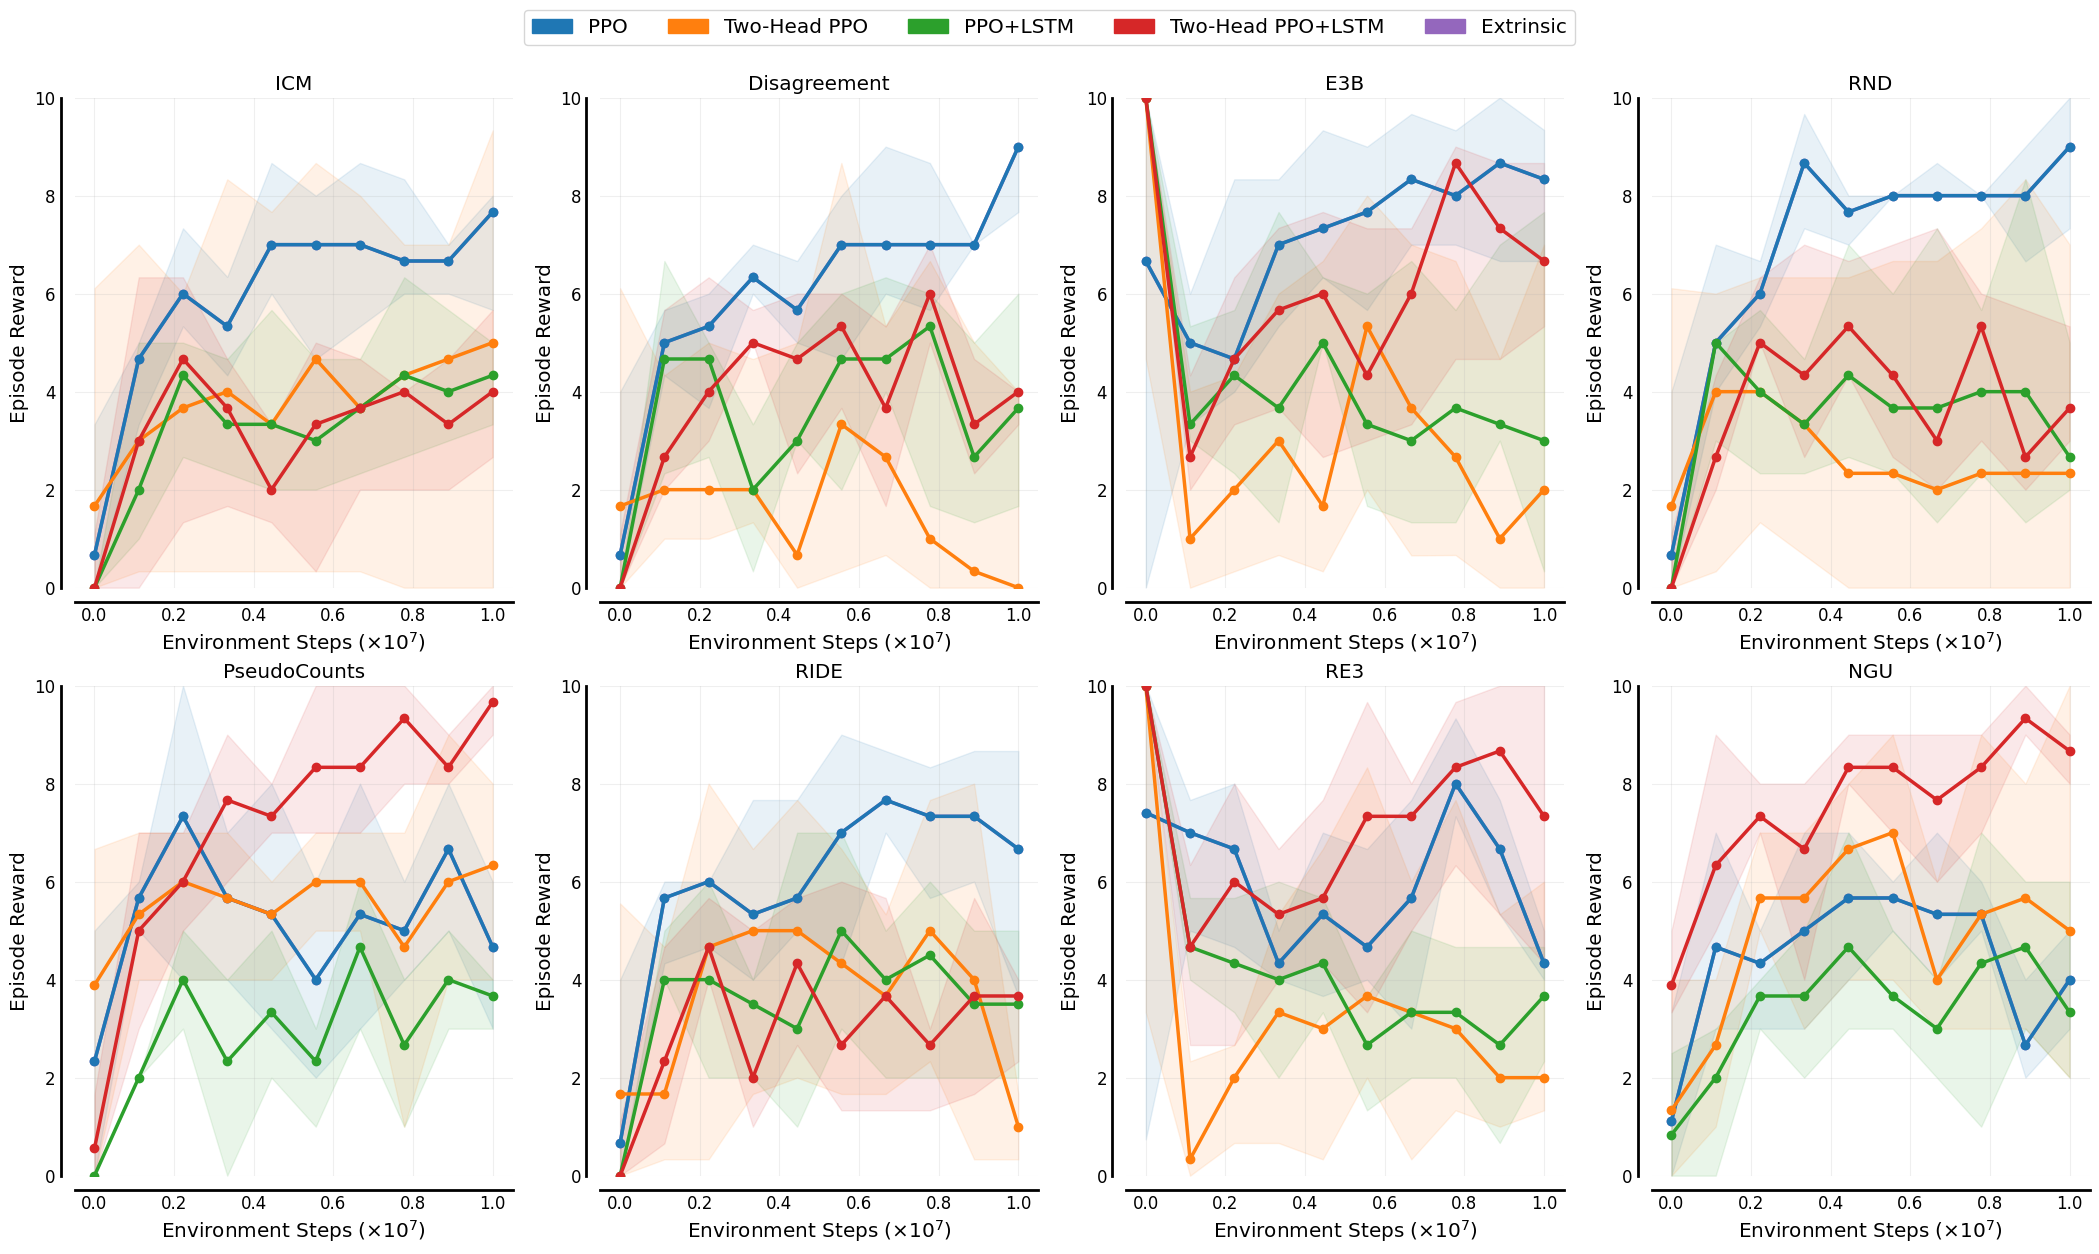

In [14]:
algos = ['ICM', 'Disagreement', 'E3B', 'RND', 'PseudoCounts', 'RIDE', 'RE3', 'NGU', 'Extrinsic']
# colors = sns.color_palette("husl", len(algos))
# colors = sns.husl_palette(3, h=.5)
colors = sns.color_palette()
fake_patches = [mpatches.Patch(color=colors[i], label=alg) for i, alg in enumerate(
    ['PPO', 'Two-Head PPO', 'PPO+LSTM', 'Two-Head PPO+LSTM', 'Extrinsic'])]

fig, axes = plt.subplots(2, 4, figsize=(26, 14))
legends = ['PPO', 'Two-Head PPO', 'PPO+LSTM', 'Two-Head PPO+LSTM']
lines = []

for subplot_idx, candidate in enumerate(['PPO_AllMazeMemory', 
                                         'twoHeadPPO_AllMazeMemory',
                                         'PPO_LSTM_AllMazeMemory',
                                         'twoHeadPPO_LSTM_AllMazeMemory'
                                         ]):
    root = f"/Users/yuanmingqi/Downloads/nips2024_data/q6/AllMazeMemory/"
    num_points = 10
    all_data = {algo: [] for algo in algos}

    for algo in algos:
        for dir in os.listdir(root):
            if algo.lower() in dir and dir.startswith(candidate):
                file = f"{root}/{dir}/"
                file = file + difflib.get_close_matches("2024-", os.listdir(file), 1, 0.1)[0] + '/train.log'
                data = pd.read_csv(file)['episode_reward']
                data = data[np.linspace(0, data.shape[0]-1, num_points, dtype=int)]
                all_data[algo].append(data)

        all_data[algo] = np.array(all_data[algo])
        all_data[algo] = np.expand_dims(all_data[algo], axis=1)
        print(candidate, algo, all_data[algo].shape)

    sampling_dict = dict()
    for algo in algos:
        if algo.lower() == 'extrinsic' and subplot_idx != 0:
            continue
        sampling_dict[algo] = [[], [], []]
        for frame in range(num_points):
            perf = Performance(all_data[algo][:, :, frame], get_ci=True, reps=2000)
            value, CIs = perf.aggregate_iqm()
            sampling_dict[algo][0].append(value)
            sampling_dict[algo][1].append(CIs[0]) # lower bound
            sampling_dict[algo][2].append(CIs[1]) # upper bound

        sampling_dict[algo][0] = np.array(sampling_dict[algo][0]).reshape(-1)
        sampling_dict[algo][1] = np.array(sampling_dict[algo][1]).reshape(-1)
        sampling_dict[algo][2] = np.array(sampling_dict[algo][2]).reshape(-1)

    for algo_idx, algo in enumerate(algos[:-1]):
        mean, ci_high, ci_low = sampling_dict[algo]
        ax = axes.flatten()[algo_idx]
        x = np.linspace(0, 1, num_points)
        if subplot_idx == 0:
            # ax.axhline(y=30.0, color='k', linestyle='--', linewidth=2, label="Extrinsic")
            ax.plot(x, mean, linewidth=2.5, marker='o', markersize=6, c=colors[4], label='Extrinsic')
        ax.plot(x, mean, linewidth=2.5, marker='o', markersize=6, c=colors[subplot_idx], label=legends[subplot_idx])
        ax.fill_between(x, ci_high, ci_low, alpha=0.1, color=colors[subplot_idx])
        ax.set_ylim(0, 10)
        ax.set_title(algos[algo_idx], fontsize="x-large")
        ax = _annotate_and_decorate_axis(ax, 
                                        ticklabelsize="large",
                                        xlabel=r"Environment Steps ($\times 10^7$)", 
                                        ylabel="Episode Reward",
                                        xticklabels=np.linspace(0, 1, num_points),
                                        )
        
fig.legend(fake_patches, ['PPO', 'Two-Head PPO', 'PPO+LSTM', 'Two-Head PPO+LSTM', 'Extrinsic'], loc='upper center', 
    fancybox=True, ncol=len(algos), 
    fontsize='x-large',
    bbox_to_anchor=(0.5, 0.95))
fig.savefig('figure_rq6_curves_allmazememory.pdf', bbox_inches='tight', dpi=300)

### Bar

/home/roger/Desktop/rllte/all_mario_runs//obs. norm./PPO_SuperMarioBros-1-1-v3_re3_obsRMS:True_rewNorm:rms_updateProp:1.0_rff:False_s1//2024-02-13-07-43-46/train.log


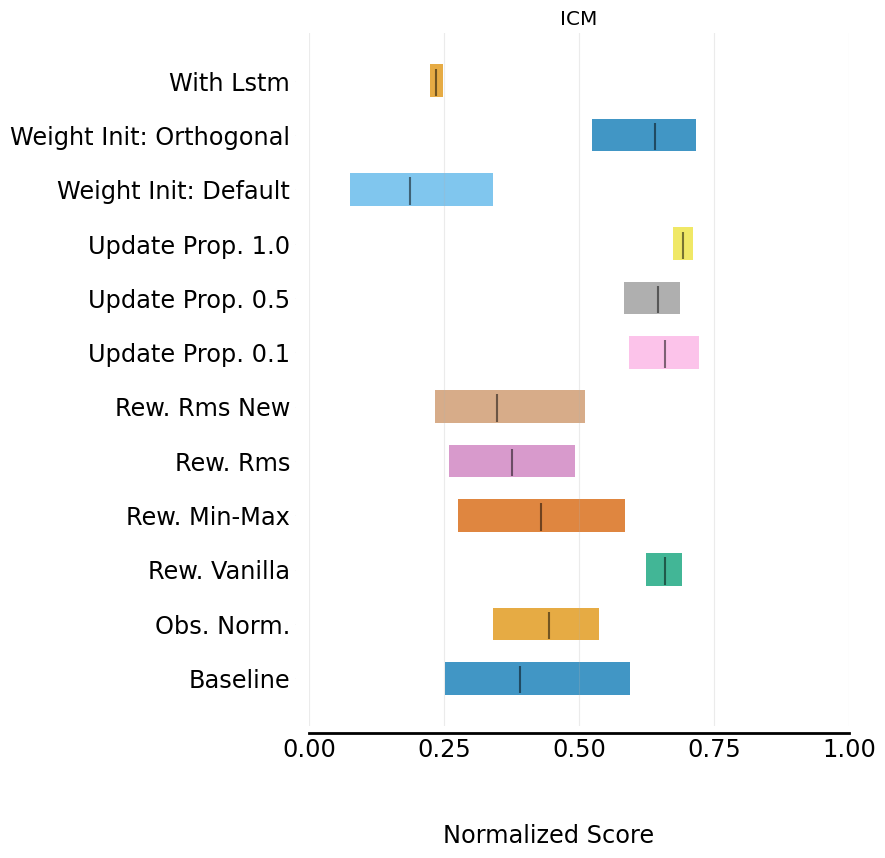

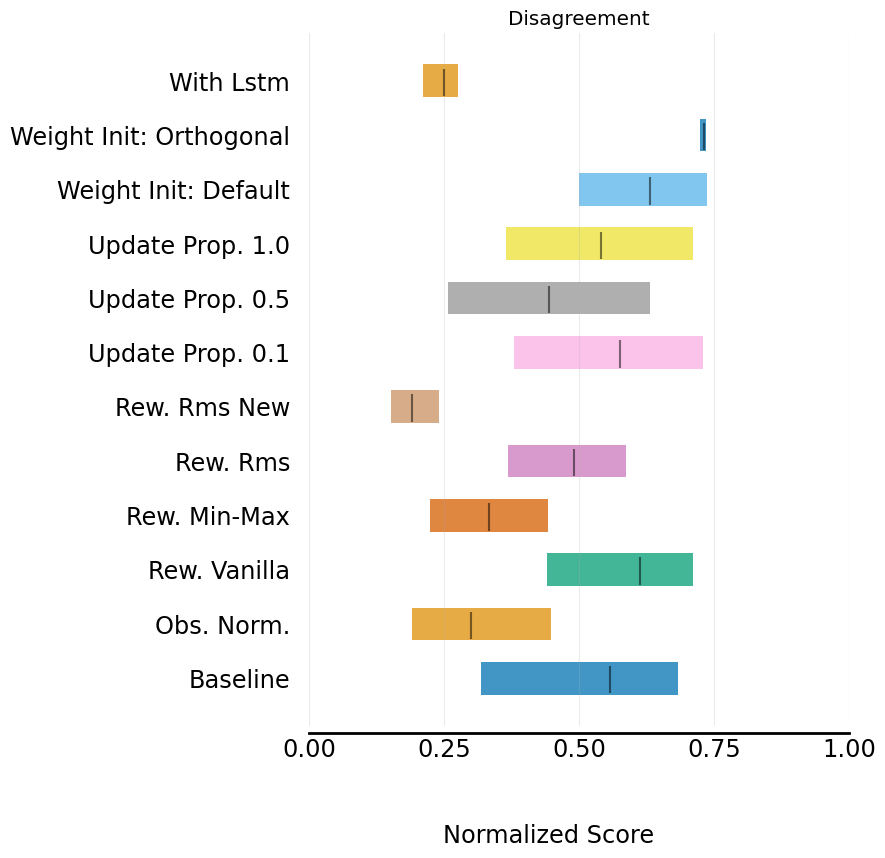

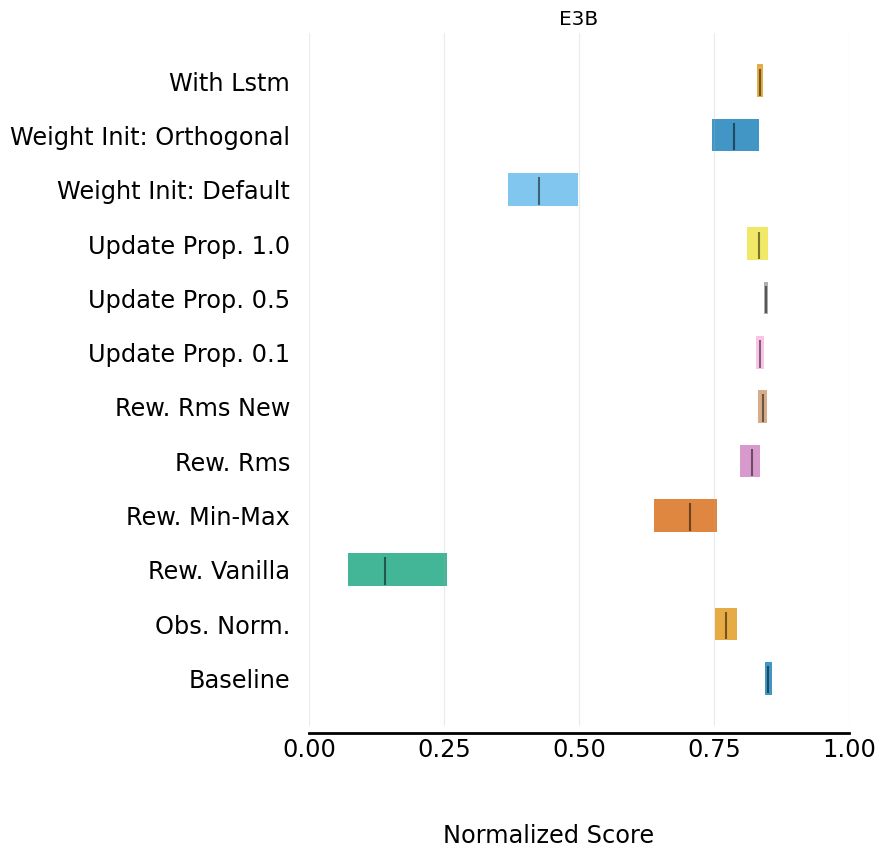

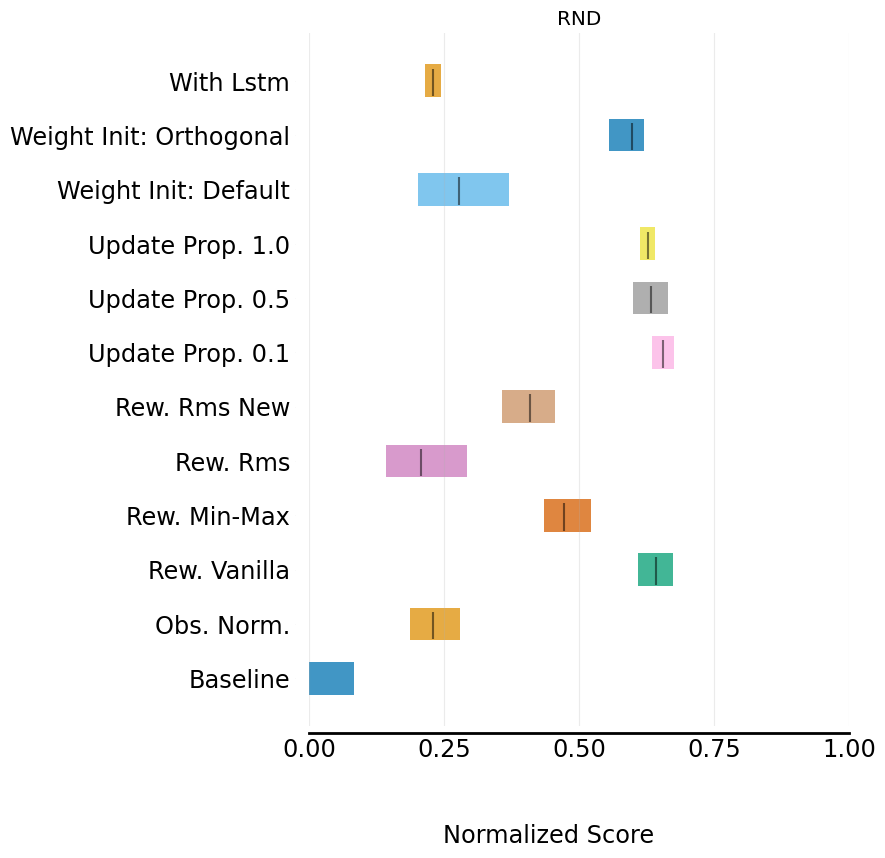

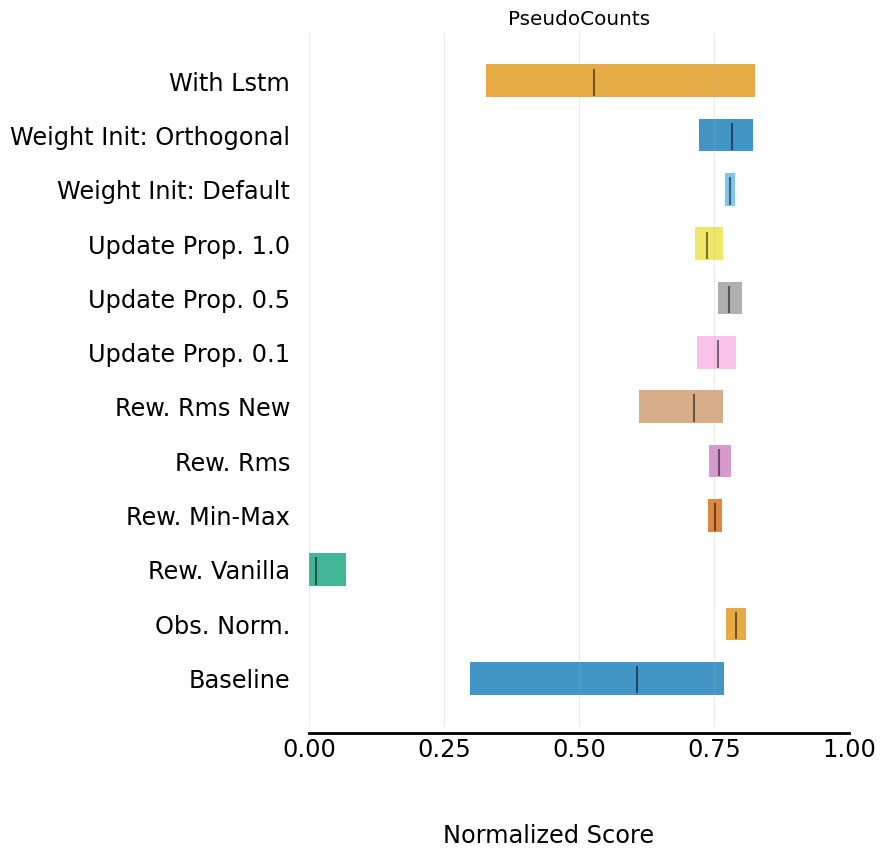

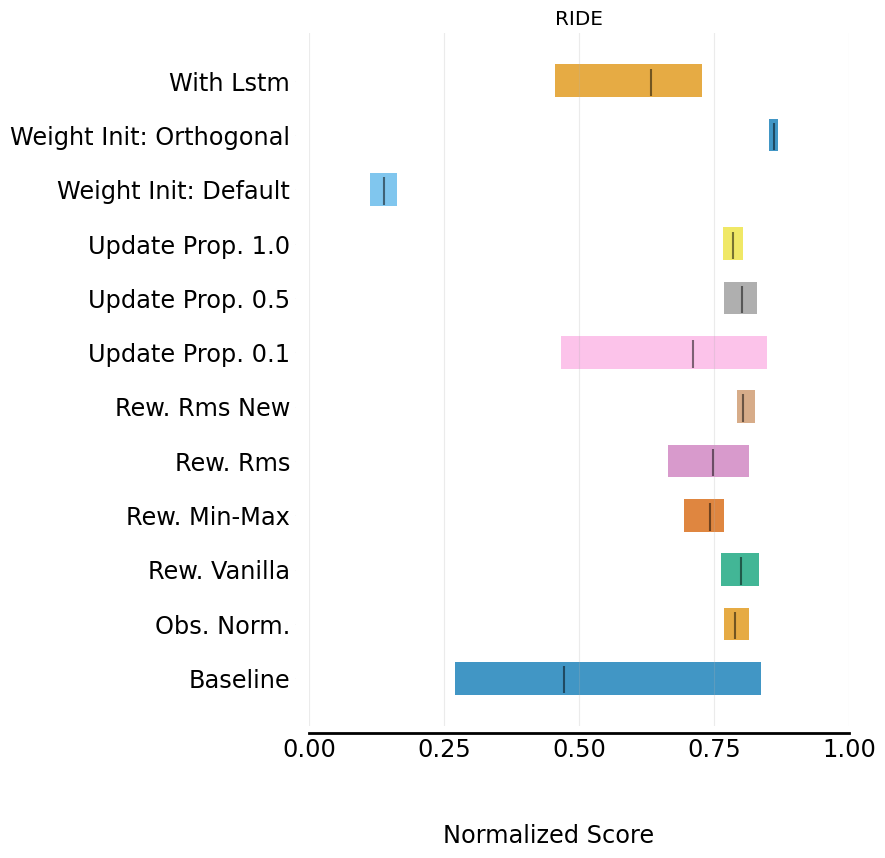

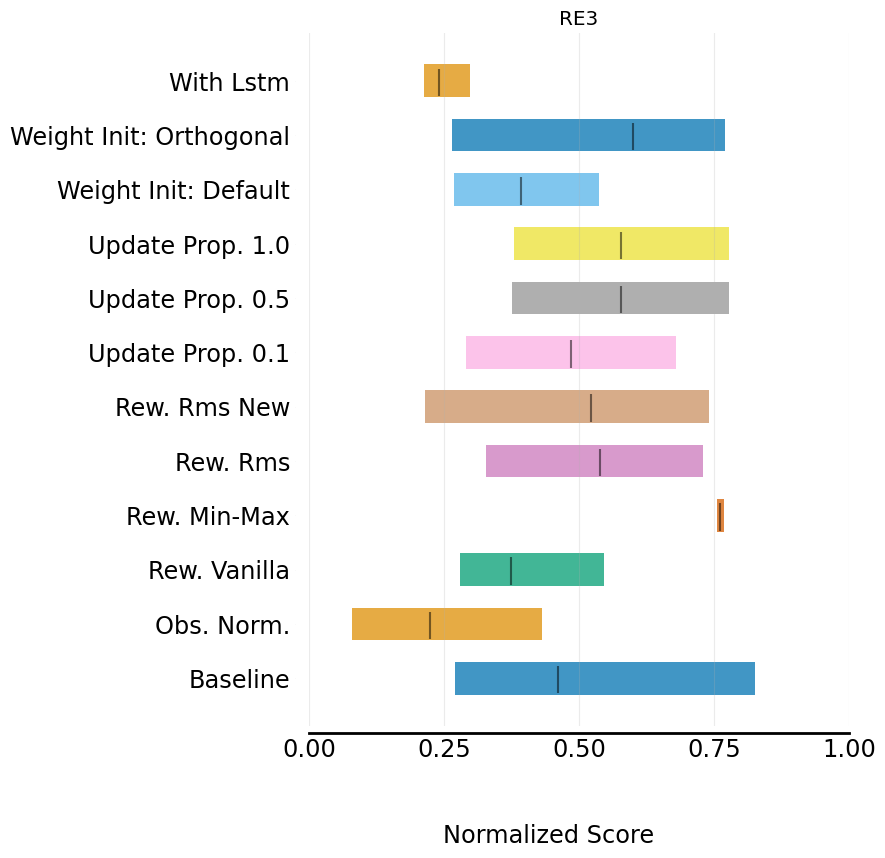

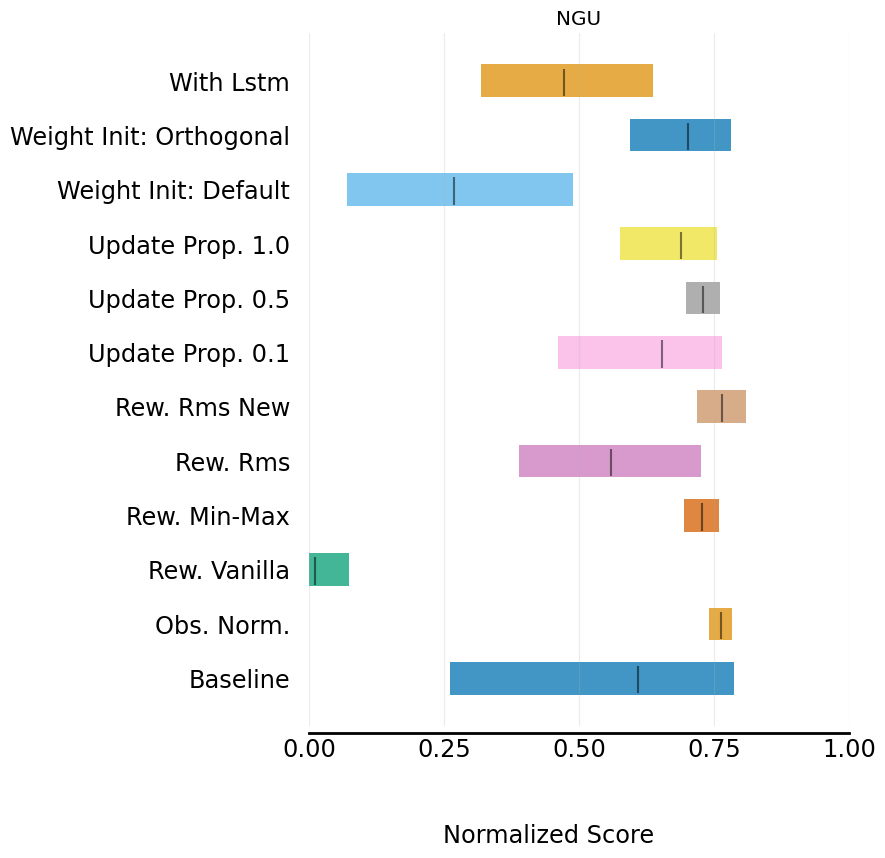

In [10]:
algos = ['ICM', 'Disagreement', 'E3B', 'RND', 'PseudoCounts', 'RIDE', 'RE3', 'NGU']
for algo in algos:
    num_last_episodes = 100
    max_episode_return = 35
    root = "/home/roger/Desktop/rllte/all_mario_runs/"
    types = ['Baseline', 'Obs. Norm.', 'Rew. Vanilla', 'Rew. Min-Max', 'Rew. Rms', 'Rew. Rms New', 'Update Prop. 0.1', 'Update Prop. 0.5', 'Update Prop. 1.0', 'Weight Init: Default', 'Weight Init: Orthogonal', 'With Lstm']
    colors = sns.color_palette("husl", len(types))
    all_data = {type: [] for type in types}

    for type in types:
        for dir in os.listdir(root + type.lower()):
            if algo.lower() in dir:
                file = f"{root}/{type.lower()}/{dir}/"
                file = file + '/' + difflib.get_close_matches("2024-", os.listdir(file), 1, 0.1)[0] + '/train.log'
                try:
                    data = pd.read_csv(file)['episode_reward']
                except:
                    print(file)
                    continue
                data = data[-num_last_episodes:]
                all_data[type].append(data)

        all_data[type] = np.array(all_data[type]).mean(axis=1, keepdims=True) / max_episode_return

    aggregate_performance_dict = {
        "MEAN": {},
        #"MEDIAN": {},
        #"IQM": {},
        #"OG": {}
    }
    for type in all_data.keys():
        perf = Performance(scores=all_data[type], get_ci=True)
        aggregate_performance_dict['MEAN'][type] = perf.aggregate_mean()
        #aggregate_performance_dict['MEDIAN'][type] = perf.aggregate_median()
        #aggregate_performance_dict['IQM'][type] = perf.aggregate_iqm()
        #aggregate_performance_dict['OG'][type] = perf.aggregate_og()

    fig, ax = plot_interval_estimates(aggregate_performance_dict, 
                                    metric_names=['MEAN'],# 'IQM'], #'MEDIAN', 'IQM', 'OG'], 
                                    algorithms=types, 
                                    xlabel="Normalized Score",
                                    subfigure_width=6,
                                    xlabel_y_coordinate=-0.02,
                                    row_height=0.75)
    
    # set 1 single title to algo
    #for ax in axes:
    ax.set_title(algo, fontsize="x-large")

    #for ax in axes:
    ax.set_xlim([0, 1])
        
    #for ax in axes:
    # ax.axhline(y=0.5, color='k', linestyle='--', linewidth=2, alpha=0.5)
    # ax.axhline(y=1.5, color='k', linestyle='--', linewidth=2, alpha=0.5)
    # ax.axhline(y=4.5, color='k', linestyle='--', linewidth=2, alpha=0.5)
    # ax.axhline(y=7.5, color='k', linestyle='--', linewidth=2, alpha=0.5)
    # ax.axhline(y=9.5, color='k', linestyle='--', linewidth=2, alpha=0.5)